<a href="https://colab.research.google.com/github/machar94/stockprediction/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Optimization" data-toc-modified-id="Model-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Optimization</a></span></li></ul></div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/achar/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


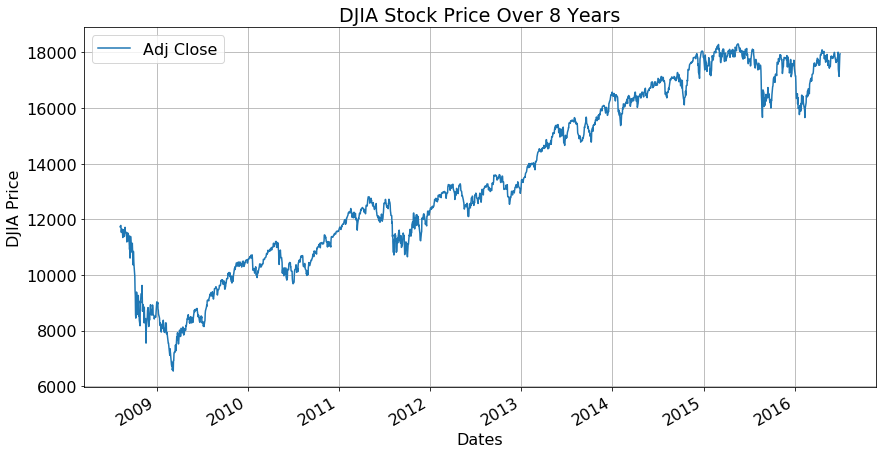

In [165]:
import os
import talib
import nltk
import warnings
import numpy as np
import pandas as pd
from pmdarima import auto_arima
import pmdarima as pm
from os.path import isfile, join
from matplotlib import pyplot as plt
from tqdm.notebook import tnrange
from functools import wraps
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
%matplotlib inline

####################
# Pre Process Prices
####################

# Open the data file
data_path = 'data/'
filename = 'djia.csv'
full_path = join(data_path, filename)
assert (isfile(full_path))

# Reads in data and checks to see none of the data is null
df_prices = pd.read_csv(full_path)
assert (df_prices.isnull().sum().sum() == 0)

# Processes file so that data is indexed by date
df_prices = df_prices.sort_values(by='Date')
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.set_index('Date', inplace=True)

plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(11, 5))
ax = fig.add_axes([0, 0, 1, 1])
df_prices.plot(y='Adj Close', ax=ax)
ax.set_xlabel('Dates')
ax.set_ylabel('DJIA Price')
ax.set_title('DJIA Stock Price Over 8 Years')
fig.autofmt_xdate(rotation=30)
ax.grid()
plt.show()

In [166]:
####################
# Pre Process Prices
####################

# Open the data file
data_path = 'data/'
filename = 'djia_headlines.csv'
full_path = join(data_path, filename)
assert (isfile(full_path))

# Reads in data and checks to see none of the data is null
df_news = pd.read_csv(full_path)

# Processes file so that data is indexed by date
df_news = df_news.sort_values(by='Date')
df_news['Date'] = pd.to_datetime(df_news['Date'])
df_news.set_index('Date', inplace=True)

# Cleanup
# Uppercase words help with VADER so do not do this
# df = df.apply(lambda x: x.astype(str).str.lower())
df_news = df_news.apply(lambda x: x.astype(str))

df_news.drop(['Label'], inplace=True, axis=1)
# Removes b and "
df_news = df_news.applymap(lambda x: x.lstrip('b" ').rstrip('"'))
# Removes '
df_news = df_news.applymap(lambda x: x.lstrip("b'").rstrip("'"))
to_replace = {
    '\\r\\n': ' ',
    '\\n': ' ',
    '\\r': ' ',
    '\\t': ' ',
    '\\s': ' ',
    "\\\\\\'": "'",
    "\\'": "'"
}

df_news = df_news.replace(to_replace, regex=True)
df_news.head(10)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.,Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,Georgian troops retreat from S. Osettain capit...,Did the U.S. Prep Georgia for War with Russia?,...,Georgia Invades South Ossetia - if Russia gets...,Al-Qaeda Faces Islamist Backlash,"Condoleezza Rice: ""The US would not act to pre...",This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Ossetia,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge
2008-08-11,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict,Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked,What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,Welcome To World War IV! Now In High Definition!,"Georgia's move, a mistake of monumental propor...",...,Israel and the US behind the Georgian aggression?,"""Do not believe TV, neither Russian nor Georgi...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer,War in South Ossetia [PICS],Israeli Physicians Group Condemns State Torture,Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war,So this is what it's come to: trading sex for ...
2008-08-12,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation,"""If we had no sexual harassment we would have ...",Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the West,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,The US military was surprised by the timing an...,U.S. Beats War Drum as Iran Dumps the Dollar,...,U.S. troops still in Georgia (did you know the...,Why Russias response to Georgia was right,"Gorbachev accuses U.S. of making a ""serious bl...","Russia, Georgia, and NATO: Cold War Two",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection,All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?,BBC NEWS | Asia-Pacific | Extinction 'by man n...
2008-08-13,U.S. refuses Israel weapons to attack Iran: r...,When the president ordered to attack Tskhinval...,Israel clears troops who killed Reuters camer...,"Britain's policy of being tough on drugs is ""p...",Body of 14 year old found in trunk; Latest (ra...,China has moved 10 *million* quake survivors i...,Bush announces Operation Get All Up In Russia'...,Russian forces sink Georgian ships,The commander of a Navy air reconnaissance squ...,92% of CNN readers: Russia's actions in Georgi...,...,Elephants extinct by 2020?,US humanitarian missions soon in Georgia - if ...,Georgia's DDOS came from US sources,"Russian convoy heads into Georgia, violating t...",Israeli defence minister: US against strike on...,Gorbachev: We Had No Choice,Witness: Russian forces head towards Tbilisi i...,Quarter of Russians blame U.S. for conflict: ...,Georgian president says US military will take...,2006: Nobel laureate Aleksander Solzhenitsyn a...
2008-08-14,All the experts admit that we

In [168]:
def plotSignal(func):
    @wraps(func)
    def wrapper(prices, signal, plot=False):
        func(prices, signal)

        if plot:
            plt.rcParams['font.size'] = 16
            fig = plt.figure(figsize=(8, 4))
            ax = fig.add_axes([0, 0, 1, 1])
            plt.plot(prices.index, signal['data'])
            ax.set_title(func.__name__)
            ax.set_xlabel('Dates')
            fig.autofmt_xdate(rotation=30)
            ax.grid()
            plt.show()

    return wrapper


def useFile(func):
    @wraps(func)
    def wrapper(prices, signal):

        # Set the filename to search for loading
        directory = 'features/'
        if signal['file'] is not None:
            fn = signal['file']
        else:
            fn = directory + func.__name__ + '.npy'

        # Load features if numpy file exists
        if isfile(fn):
            print(f'Loading {func.__name__} from {fn} ...')
            signal['data'] = np.load(fn)
        else:
            func(prices, signal, func.__name__)
            os.makedirs(directory, exist_ok=True)
            np.save(fn, signal['data'])

    return wrapper


def arima(price, window, desc):

    pred = np.full(price.shape, np.nan)
    for i in tnrange(window, price.shape[0], desc=desc):

        train = price[i - window:i]

        if np.any(np.isnan(train)):
            continue

        with warnings.catch_warnings():
            # Uninvertible hessian
            warnings.filterwarnings('ignore', 'Inverting')
            # RuntimeWarning: invalid value encountered in true_divide
            warnings.filterwarnings('ignore', 'invalid')
            # RuntimeWarning: overflow encountered in exp
            warnings.filterwarnings('ignore', 'overflow')
            # ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
            # warnings.filterwarnings('ignore', 'Maximum')
            # RuntimeWarning: divide by zero encountered in true_divide
            warnings.filterwarnings('ignore', 'divide')

            # Initialize model
            model = auto_arima(train,
                               max_p=3,
                               max_q=3,
                               seasonal=False,
                               trace=False,
                               error_action='ignore',
                               suppress_warnings=True)

            # Determine model parameters
            model.fit(train)
            order = model.get_params()['order']

            # Fit and predict
            model = pm.ARIMA(order=order)
            model.fit(train)
            pred[i] = model.predict(1)

    return pred


@plotSignal
def sma(prices, signal):
    """
    Simple Moving Average
    """

    window = signal['params']['window']
    signal['data'] = talib.SMA(prices['close'], window).to_numpy()[:, None]


@plotSignal
def wma(prices, signal):
    """
    Weighted Moving Average
    """

    window = signal['params']['window']
    signal['data'] = talib.WMA(prices['close'], window).to_numpy()[:, None]


@plotSignal
def mom(prices, signal):
    """
    Momentum
    """

    window = signal['params']['window']
    signal['data'] = talib.MOM(prices['close'], window).to_numpy()[:, None]


@plotSignal
def macd(prices, signal):
    """
    Moving Average Convergence Divergence
    """

    fast = signal['params']['fastperiod']
    slow = signal['params']['slowperiod']
    mavg = signal['params']['signalperiod']

    macd, macdsignal, _ = talib.MACD(prices['close'], fast, slow, mavg)

    signal['data'] = np.hstack(
        [macd.to_numpy()[:, None],
         macdsignal.to_numpy()[:, None]])


@plotSignal
def rsi(prices, signal):
    """
    Relative Strength Index
    """

    window = signal['params']['window']
    signal['data'] = talib.RSI(prices['close'], window).to_numpy()[:, None]


@plotSignal
def stoch(prices, signal):
    """
    Stochastics
    """

    slowk, slowd = talib.STOCH(prices['high'], prices['low'], prices['close'])

    signal['data'] = np.hstack(
        [slowk.to_numpy()[:, None],
         slowd.to_numpy()[:, None]])


@plotSignal
def willr(prices, signal):
    """
    Williams R Oscillator
    """

    window = signal['params']['window']
    signal['data'] = talib.WILLR(prices['high'], prices['low'],
                                 prices['close'], window).to_numpy()[:, None]


@plotSignal
def adosc(prices, signal):
    """
    Accumulation / Distribution Oscillator
    """

    signal['data'] = talib.ADOSC(prices['high'],
                                 prices['low'],
                                 prices['close'],
                                 prices['volume'],
                                 fastperiod=3,
                                 slowperiod=10).to_numpy()[:, None]


@plotSignal
def ema(prices, signal):
    """
    Exponential Moving Average
    """

    window = signal['params']['window']
    signal['data'] = talib.EMA(prices['close'], window).to_numpy()[:, None]


@plotSignal
@useFile
def arima_sma(prices, signal, name):
    """
    ARIMA on Simple Moving Average
    """

    sma_window = signal['params']['sma_window']
    sma_close = talib.SMA(prices['close'], sma_window).to_numpy()[:, None]
    signal['data'] = arima(sma_close, signal['params']['arima_window'], name)


@plotSignal
@useFile
def arima_wma(prices, signal, name):
    """
    ARIMA on Weighted Moving Average
    """

    wma_window = signal['params']['wma_window']
    wma_close = talib.WMA(prices['close'], wma_window).to_numpy()[:, None]
    signal['data'] = arima(wma_close, signal['params']['arima_window'], name)


@plotSignal
@useFile
def arima_ema(prices, signal, name):
    """
    ARIMA on Exponential Moving Average
    """

    ema_window = signal['params']['ema_window']
    ema_close = talib.EMA(prices['close'], ema_window).to_numpy()[:, None]
    signal['data'] = arima(ema_close, signal['params']['arima_window'], name)

In [169]:
# Other Helper Functions


def resetSignals(indicators):
    """
    Creates a signals structure given list of functions
    """
    signals = {}

    for func in indicators:
        signals[func.__name__] = {}
        signals[func.__name__]['func'] = func
        signals[func.__name__]['params'] = {}
        signals[func.__name__]['data'] = None
        signals[func.__name__]['file'] = None

    return signals


def getHeadlineScores(headlines):
    analyser = SentimentIntensityAnalyzer()
    getscore = lambda x: analyser.polarity_scores(x)['compound']
    sentiment = headlines.applymap(getscore)
    return sentiment


def extractFeatures(prices, headlines, signals):
    """
    Calculate signals based on items in dictionary
    """
    for k, signal in signals.items():
        signal['func'](prices, signal, plot=False)

    sentiment = getHeadlineScores(headlines)

    return signals, sentiment


def prepareLabels(prices, predict):
    """
    Calculates label depending on future price
    0 - price predict days ahead is down (trend down)
    1 - price predict days ahead is up (trend up)
    """

    # Because np.nan is represented as a large negative number,
    # wait to change labels to int type until after cleaning data
    close = prices['close']
    labels = np.full(close.shape, np.nan)
    for i in range(0, len(close) - predict):
        labels[i] = close[i + predict] - close[i]

    with warnings.catch_warnings():
        # Comparison with nan values creates warnings
        warnings.filterwarnings('ignore', 'invalid')
        labels[labels >= 0] = 1
        labels[labels < 0] = 0

    return labels


def writeToFile(labels, dates, sentiment, signals, predict):

    # Create an empty pandas frame
    df = pd.DataFrame(index=dates)

    # Add all indicators to df
    for column, value in signals.items():
        if signals[column]['data'].shape[1] > 1:
            for i in range(signals[column]['data'].shape[1]):
                df[column + str(i)] = pd.Series(signals[column]['data'][:, i],
                                                index=df.index)
        else:
            df[column] = pd.Series(signals[column]['data'].flatten(),
                                   index=df.index)

    # Add all headlines to df
    df = pd.concat([df, sentiment], axis=1)

    # Add labels to df
    df['labels'] = pd.Series(labels.flatten(), index=df.index)

    # Save to a file features/all_features.csv
    directory = 'features/'
    os.makedirs(directory, exist_ok=True)
    fn = directory + 'all_features_predict_' + str(predict) + '.csv'
    df.to_csv(fn)


def getCleanData(prices, headlines, signals, predict=1, verbose=True):
    """
    Removes rows 
    """
    signals, sentiment = extractFeatures(prices, headlines, signals)
    labels = prepareLabels(prices, predict)

    # Create a N x D matrix of samples vs features
    features = [v['data'] for _, v in signals.items()]
    features.append(sentiment.values)
    features = np.hstack(features)

    writeToFile(labels, prices.index, sentiment, signals, predict)

    # Remove rows with nans
    rowsbool = np.isnan(features).any(axis=1)
    rowsbool = np.logical_or(rowsbool, np.isnan(labels))
    rows = np.arange(features.shape[0])[rowsbool]

    # Checks if all rows are continuous
    diffs = np.diff(np.arange(features.shape[0])[~rowsbool])
    if ~((diffs == 1).all()):
        print('Warning, time series data is not continuous!')

    if verbose:
        print(f'Removing the following times')
        print(f'============================')
        fmtr = lambda x: x.strftime('%Y/%m/%d')
        for row, time in zip(rows, prices.index[rows].format(formatter=fmtr)):
            print(f'row: {row:>4}   time: {time}')
    else:
        print(f'Removing {len(rows)} rows from data')

    features = features[~rowsbool, :]
    labels = labels[~rowsbool]

    return features, labels


def create_sequences(features, labels, seq_length):
    """
    Returns a (T,H,D) numpy array
    T - number of data points
    H - history size of lstm
    D - dimension of data X
    """

    N, D = features.shape
    T = N - seq_length + 1
    xs = np.empty((T, seq_length, D))
    ys = np.empty((T, 1), dtype=np.int)

    for i in range(T):
        xs[i] = np.copy(features[i:(i + seq_length), :])
        ys[i] = np.copy(labels[i])

    return xs, ys

In [170]:
prices = df_prices.filter(['High', 'Low', 'Volume', 'Adj Close'], axis=1)

names = {
    'High': 'high',
    'Low': 'low',
    'Volume': 'volume',
    'Adj Close': 'close'
}

prices.rename(columns=names, inplace=True)

technical_indicators = [
    sma,  # Simple Moving Average
    wma,  # Weighted Moving Average
    mom,  # Exponential Moving Average
    macd,  # Moving Average Convergence Divergence
    rsi,  # Relative Strength Indicator
    stoch,  # Stochastic %K and %D
    willr,  # Larry Williams %R
    adosc,  # Accumulation / Distribution Oscillator
    arima_sma,  # ARIMA on a SMA
    arima_wma,  # ARIMA on a WMA 
    arima_ema,  # ARIMA on an EMA
]

# Prepare signals dictionary layout for uploading features
signals = resetSignals(technical_indicators)

# Set all signal parameters
signals['sma']['params']['window'] = 14
signals['wma']['params']['window'] = 14
signals['mom']['params']['window'] = 14
signals['macd']['params']['fastperiod'] = 12
signals['macd']['params']['slowperiod'] = 26
signals['macd']['params']['signalperiod'] = 9
signals['rsi']['params']['window'] = 14
signals['willr']['params']['window'] = 14

signals['arima_sma']['params']['sma_window'] = 3
signals['arima_sma']['params']['arima_window'] = 30
signals['arima_sma']['file'] = 'features/djia_arima_sma.npy'

signals['arima_wma']['params']['wma_window'] = 3
signals['arima_wma']['params']['arima_window'] = 30
signals['arima_wma']['file'] = 'features/djia_arima_wma.npy'

signals['arima_ema']['params']['ema_window'] = 3
signals['arima_ema']['params']['arima_window'] = 30
signals['arima_ema']['file'] = 'features/djia_arima_ema.npy'

headlines = df_news.filter(['Date', 'Top1', 'Top2', 'Top3', 'Top4', 'Top5'],
                           axis=1)

features, labels = getCleanData(prices, headlines, signals, predict=7, verbose=False)

Loading arima_sma from features/djia_arima_sma.npy ...
Loading arima_wma from features/djia_arima_wma.npy ...
Loading arima_ema from features/djia_arima_ema.npy ...
Removing 40 rows from data


In [219]:
# %pip install jupyterplot
import time, copy, torch
from torch import nn, optim
from jupyterplot import ProgressPlot
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

seed = 42
torch.manual_seed(seed)

In [172]:
class Dataset(torch.utils.data.Dataset):
    """
    Characterizes a dataset for PyTorch
    """
    def __init__(self, data, labels):
        'Initialization'
        self.data = data
        self.labels = labels

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.data[index]
        y = self.labels[index]

        return X, y

In [173]:
# Prepare data for nn training
batch_size = 14
n_features = features.shape[1]

# Want to perform this on full data set before splitting
# otherwise some numbers might be larger in validation set
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler = scaler.fit(features)
scaled = scaler.transform(features)

x_all, y_all = create_sequences(scaled, labels, seq_length=10)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x_all,
                                                    y_all,
                                                    test_size=0.25,
                                                    # random_state=seed)
                                                    shuffle=False)

print('X Train Shape: ', X_train.shape)
print('X Test Shape: ', X_test.shape)
print('Y Train Shape: ', y_train.shape)
print('Y Test Shape: ', y_test.shape)

data_sets = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_test, y_test)
}
dataloaders = {
    x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

X Train Shape:  (1455, 10, 18)
X Test Shape:  (485, 10, 18)
Y Train Shape:  (1455, 1)
Y Test Shape:  (485, 1)


In [174]:
class Forecaster(nn.Module):
    def __init__(self, n_features, n_hidden, n_layers=2, dropout=0.5):
        super(Forecaster, self).__init__()

        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=dropout,
        )

        # FC Layer
        self.FC = nn.Linear(self.n_hidden, 1)

    def forward(self, x):
        # (batch, seq, features) -> (seq, batch, features)
        lstm_out, self.hidden = self.lstm(torch.transpose(x, 0, 1))

        # lstm_out[-1] is (batch, hidden)
        y_pred = self.FC(lstm_out[-1]).sigmoid()

        return y_pred

In [208]:
class Solver():
    def __init__(self, model, **kwargs):
        """
        Required arguments:
        - model: a torch.nn model object
        """

        self.model = model

        # Unpack keyword arguments
        self.batch_size = kwargs.pop('batch_size', 10)
        self.num_epochs = kwargs.pop('num_epochs', 10)

        self.mode = {}
        self.mode['plot'] = kwargs.pop('plot', False)
        self.mode['verbose'] = kwargs.pop('verbose', True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ', '.join('"%s"' % k for k in kwargs.keys())
            raise ValueError('Unrecognized arguments %s' % extra)

    def _reset(self):
        self.stats = {}
        self.stats['train'] = {
            x: np.zeros(self.num_epochs)
            for x in ['loss', 'acc']
        }
        self.stats['val'] = {
            x: np.zeros(self.num_epochs)
            for x in ['loss', 'acc']
        }

        # Enable GPU if available
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")

        if self.mode['verbose']:
            print(f'Using {self.device} for training.')

        self.best_val_acc = 0
        self.best_params = copy.deepcopy(self.model.state_dict())

        # Plotting setup
        if self.mode['plot']:
            self.pp = ProgressPlot(plot_names=['loss', 'acc'],
                                   line_names=['train', 'val'],
                                   x_lim=[0, self.num_epochs],
                                   y_lim=[0, 1])

    def _accuracy(self, preds, targets):
        # Convert to numpy since we don't want grad
        with torch.no_grad():
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            return torch.sum(torch.eq(preds, targets)).item()

    def _plotStats(self, epoch):
        data = [[
            self.stats['train']['loss'][epoch],
            self.stats['val']['loss'][epoch]
        ], [
            self.stats['train']['acc'][epoch], self.stats['val']['acc'][epoch]
        ]]

        self.pp.update(data)

    def setModel(self, model):
        self.model = model

    def train(self, dataloaders, dataset_sizes):
        self._reset()

        loss_fn = nn.BCELoss()

        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # Prepare model for running
        self.model.double()
        self.model.to(self.device)

        since = time.time()
        for epoch in range(self.num_epochs):
            for phase in ['train', 'val']:

                if phase == 'train':
                    self.model.train()
                if phase == 'val':
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        # Forward pass
                        y_preds = self.model(inputs)
                        loss = loss_fn(y_preds, labels.double())

                        batch_size = inputs.shape[0]
                        if phase == 'train':
                            loss.backward()  # Calculate gradients
                            optimizer.step()  # Update weights

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += self._accuracy(y_preds, labels)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]

                # Deep copy the model
                if phase == 'val' and epoch_acc > self.best_val_acc:
                    self.best_val_acc = epoch_acc
                    self.best_params = copy.deepcopy(self.model.state_dict())

                if self.mode['verbose']:
                    print('Epoch: {}-{:6>0} Loss: {:.4f} Acc: {:.4f}'.format(
                        epoch + 1, phase, epoch_loss, epoch_acc))

                self.stats[phase]['loss'][epoch] = epoch_loss
                self.stats[phase]['acc'][epoch] = epoch_acc

            # Realtime results plotting
            if self.mode['plot']:
                self._plotStats(epoch)

        if self.mode['verbose']:
            time_elapsed = time.time() - since
            print('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
            print('Best val acc: {:4f}'.format(self.best_val_acc))

        # Makes the plot persist across notebook sessions
        if self.mode['plot']:
            self.pp.finalize()

        # Reset model to return with the best parameters
        self.model.load_state_dict(self.best_params)

        return self.model.eval()
    
    
    def eval(self, model, dataloader):
        
        self.model.eval()
        self.model.to(self.device)
        since = time.time()
        
        ytest = torch.empty((0,1), device=self.device)
        ypred = torch.empty((0,1), device=self.device)
        
        for inputs, labels in dataloader:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            
            with torch.no_grad():
                preds = self.model(inputs)
                
            ytest = torch.cat((ytest, labels.float()), axis=0)
            ypred = torch.cat((ypred, preds.float()), axis=0)
            
        if torch.cuda.is_available():
            ytest = ytest.data.cpu().numpy()
            ypred = ypred.data.cpu().numpy()
        else:
            ytest = ytest.data.numpy()
            ypred = ypred.data.numpy()    
        
        return ytest, ypred

In [209]:
model = Forecaster(n_features=n_features, n_hidden=32, n_layers=2, dropout=0.5)
solver = Solver(model,
                batch_size=batch_size,
                num_epochs=10,
                verbose=True,
                plot=True)

model = solver.train(dataloaders, dataset_sizes)

Using cpu for training.


Epoch: 1-train Loss: 0.6162 Acc: 0.6460
Epoch: 1-val Loss: 0.5210 Acc: 0.7423
Epoch: 2-train Loss: 0.3555 Acc: 0.8619
Epoch: 2-val Loss: 0.3164 Acc: 0.8598
Epoch: 3-train Loss: 0.2972 Acc: 0.8742
Epoch: 3-val Loss: 0.2628 Acc: 0.9010
Epoch: 4-train Loss: 0.2918 Acc: 0.8715
Epoch: 4-val Loss: 0.2584 Acc: 0.9031
Epoch: 5-train Loss: 0.2633 Acc: 0.8942
Epoch: 5-val Loss: 0.2903 Acc: 0.8784
Epoch: 6-train Loss: 0.2721 Acc: 0.8832
Epoch: 6-val Loss: 0.2743 Acc: 0.8866
Epoch: 7-train Loss: 0.2682 Acc: 0.8900
Epoch: 7-val Loss: 0.2573 Acc: 0.8948
Epoch: 8-train Loss: 0.2620 Acc: 0.8907
Epoch: 8-val Loss: 0.2618 Acc: 0.8969
Epoch: 9-train Loss: 0.2635 Acc: 0.8873
Epoch: 9-val Loss: 0.2675 Acc: 0.8887
Epoch: 10-train Loss: 0.2611 Acc: 0.8907
Epoch: 10-val Loss: 0.2868 Acc: 0.8825
Training complete in 0m 10s
Best val acc: 0.903093


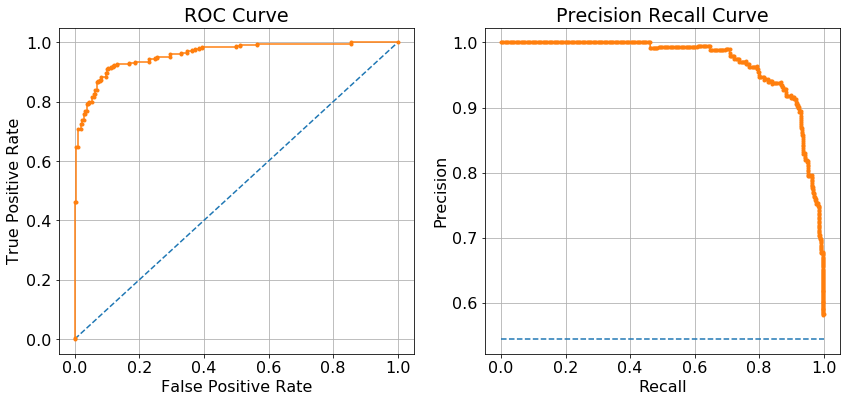

No Skill  : ROC AUC=0.500
LSTM Model: ROC AUC=0.960
LSTM Model: PR AUC=0.970


In [236]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# Model and no skill guess (always trending up)
y_test, y_pred = solver.eval(model, dataloaders['val'])
ns_pred = np.ones_like(y_pred)

fig = plt.figure(figsize=(14,6))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_pred)
ml_fpr, ml_tpr, _ = roc_curve(y_test, y_pred)

plt.subplot(1,2,1)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(ml_fpr, ml_tpr, marker='.', label='LSTM Model')
plt.grid()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ml_precision, ml_recall, _ = precision_recall_curve(y_test, y_pred)
no_skill = len(y_test[y_test==1]) / len(y_test)

plt.subplot(1,2,2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(ml_recall, ml_precision, marker='.', label='LSTM Model')
plt.grid()
plt.title('Precision Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Calculate scores
ns_roc_auc = roc_auc_score(y_test, ns_pred)
ml_roc_auc = roc_auc_score(y_test, y_pred)
ml_pr_auc = auc(ml_recall, ml_precision)

# summarize scores
print('No Skill  : ROC AUC=%.3f' % (ns_roc_auc))
print('LSTM Model: ROC AUC=%.3f' % (ml_roc_auc))
print('LSTM Model: PR AUC=%.3f' % (ml_pr_auc))

### Model Optimization

In [36]:
# %pip install scikit-optimize
from sklearn.model_selection import cross_val_score
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

In [ ]:
# Define the space of hyperparameters to search
search_space = [
    Integer(2, 128, name='n_hidden'),
    Integer(2, 4, name='n_layers'),
    Real(0.5, 0.9, name='dropout')
]


def cross_val_score(params, X, y, cv=5):

    n_hidden = int(params['n_hidden'])
    n_layers = int(params['n_layers'])
    droupout = params['dropout']

    # Split the data
    folds_x = np.array_split(X, cv)
    folds_y = np.array_split(y, cv)

    results = np.zeros(shape=(cv, ))

    for i in tnrange(cv):
        # Make a copy of the set
        X_train = folds_x.copy()
        y_train = folds_y.copy()

        # Remove the specific fold
        X_test = folds_x[i]
        y_test = folds_y[i]

        del X_train[i]
        del y_train[i]

        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        # Create dataloaders expected by solver
        data_sets = {
            'train': Dataset(X_train, y_train),
            'val': Dataset(X_test, y_test)
        }
        dataloaders = {
            x: DataLoader(data_sets[x], batch_size=batch_size, shuffle=True)
            for x in ['train', 'val']
        }
        dataset_sizes = {x: len(data_sets[x]) for x in ['train', 'val']}

        # Run model and report best validation accuracy
        model = Forecaster(n_features=n_features,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           dropout=droupout)

        solver = Solver(model,
                        batch_size=batch_size,
                        num_epochs=30,
                        verbose=False)
        model = solver.train(dataloaders, dataset_sizes)

        results[i] = solver.best_val_acc

    return results


@use_named_args(search_space)
def evaluate_model(**params):
    print(f'Evaluating model with parameters: {params}')

    # Calculate K-fold cross validation
    result = cross_val_score(params, x_all, y_all, cv=5)
    # Calculate the mean of the scores
    estimate = np.mean(result)

    return 1.0 - estimate

In [ ]:
# Perform optimization
gp_bayes_result = gp_minimize(evaluate_model, search_space, n_calls=20)
print(gp_bayes_result)
print(gp_bayes_result.x)
print(gp_bayes_result.fun)